In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats.stats import pearsonr
from scipy import stats


file = pd.read_csv("..//..//Data//CleanData_mileage_price_enginesize.csv")

file.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Aygo,2017,9250,Manual,4414,Other,150,68.9,1.0
1,Aygo,2017,7100,Manual,32351,Petrol,0,68.9,1.0
2,Aygo,2016,6500,Manual,26193,Petrol,0,69.0,1.0
3,Aygo,2017,7650,Manual,12134,Petrol,0,68.9,1.0
4,Aygo,2016,6999,Manual,21123,Petrol,0,69.0,1.0


In [7]:
#https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0



X_constant = sm.add_constant(file.mileage)
lin_reg = sm.OLS(file.price,X_constant).fit()
lin_reg.summary()

C:\Users\samslomowitz\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     5201.
Date:                Mon, 07 Feb 2022   Prob (F-statistic):               0.00
Time:                        19:38:24   Log-Likelihood:            -1.3385e+05
No. Observations:               14233   AIC:                         2.677e+05
Df Residuals:                   14231   BIC:                         2.677e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.383e+04     44.678    309.506      0.000    1.37e+04    1.39e+04
mileage       -0.1429      0.002    -72.119      0.000      -0.147      -0.139
==============================================================================
Omnibus:                     1653.645   Durbin-Watson:                   0.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2522.679
Skew:                           0.850   Prob(JB):                         0.00
Kurtosis:                       4.167   Cond. No.                     4.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

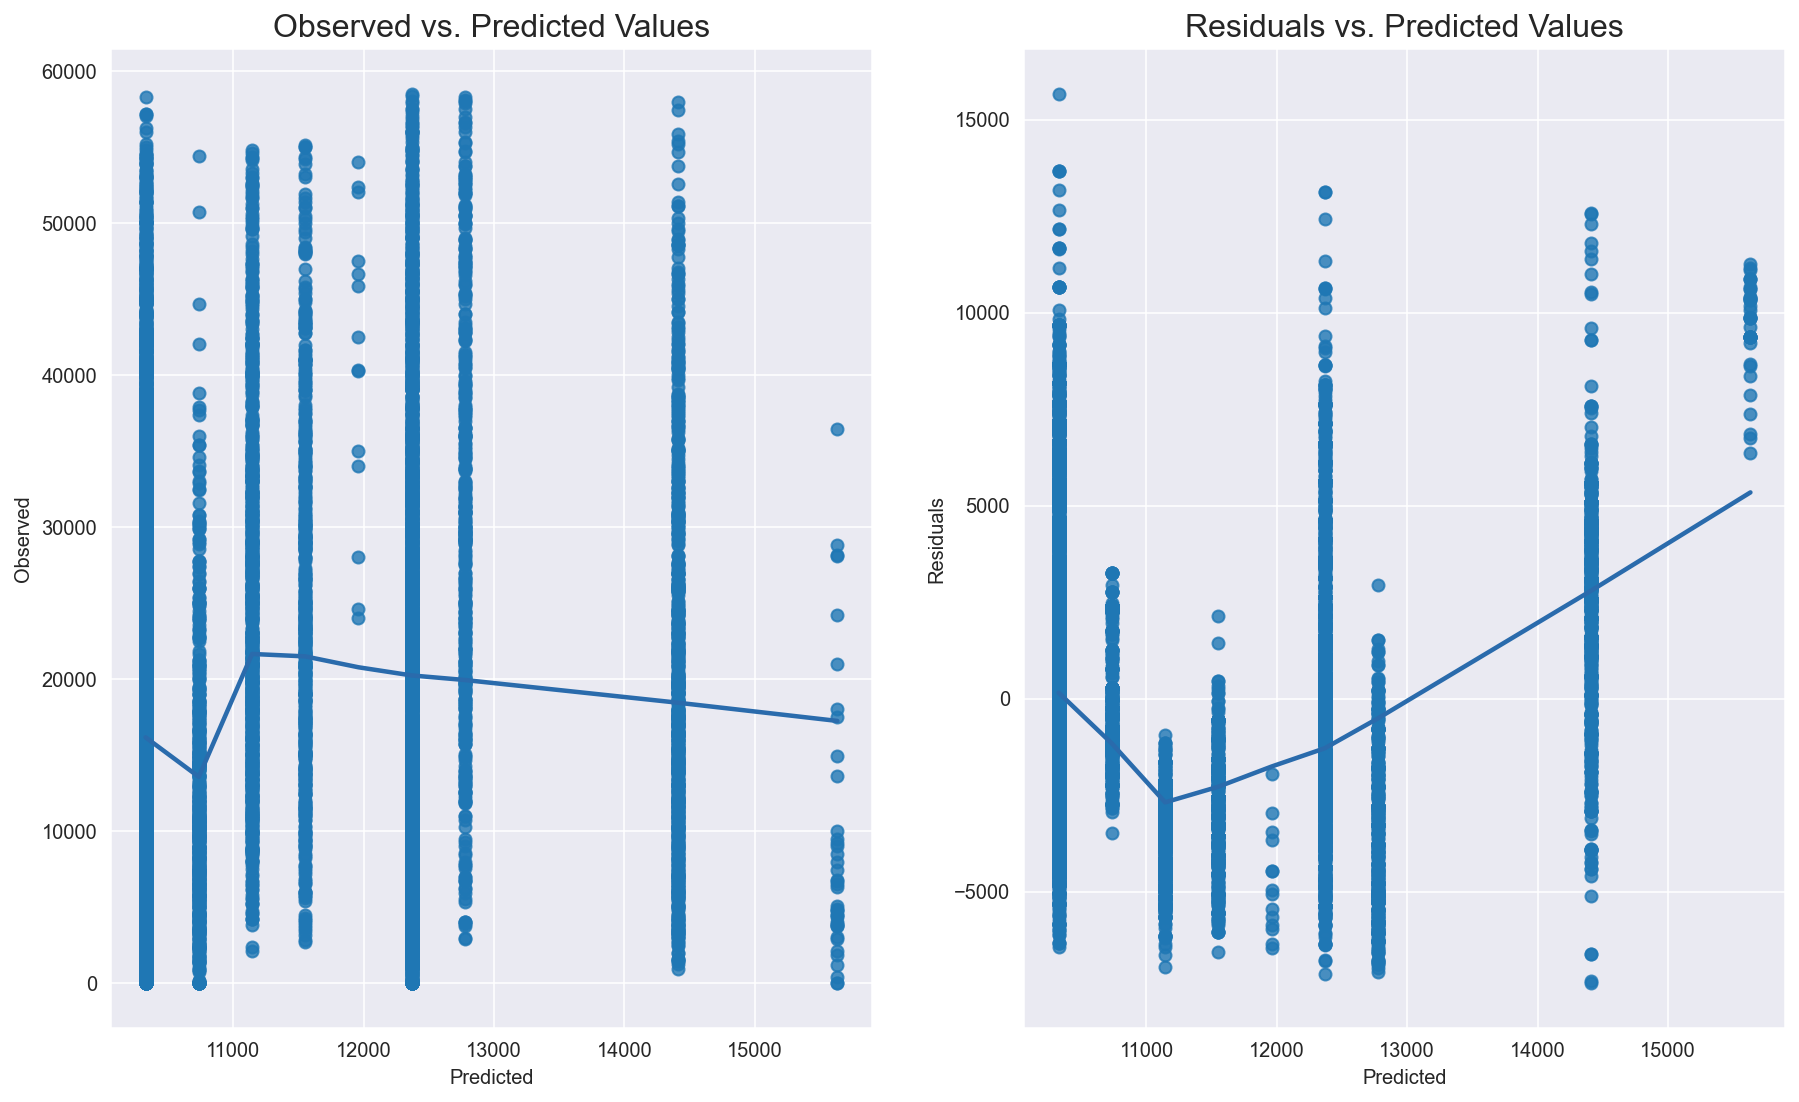

In [26]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': '#2A6BAC'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': '#2A6BAC'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(lin_reg, file.mileage)  

In [9]:
#Expectation (mean) of residuals is zero

lin_reg.resid.mean()

-2.9702194005346203e-12


 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  4.082717e+02
p-value                        8.716275e-91
f-value                        4.202697e+02
f p-value                      4.535687e-92

 Goldfeld-Quandt test ----
                     value
F statistic   1.994849e+00
p-value      3.262008e-183

 Residuals plots ----


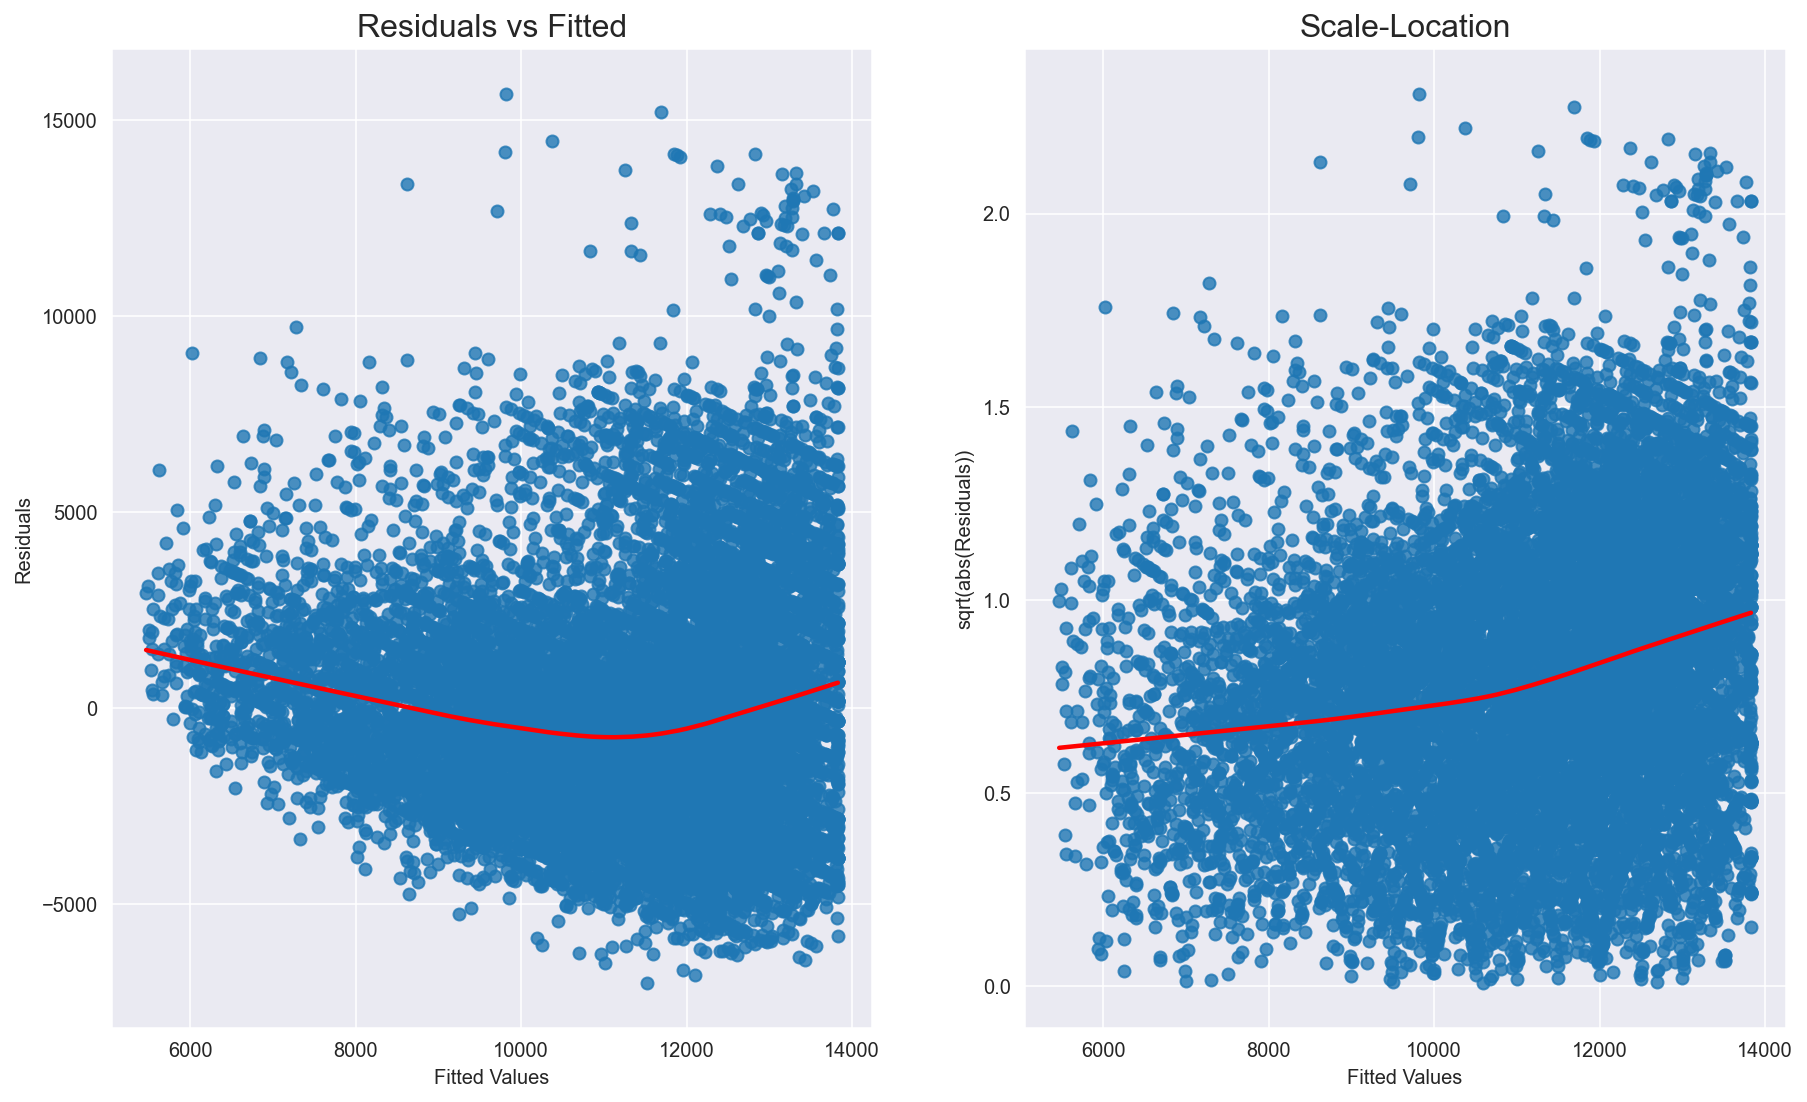

In [10]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(lin_reg)

C:\Users\SAMSLO~1\AppData\Local\Temp/ipykernel_17016/3470893239.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


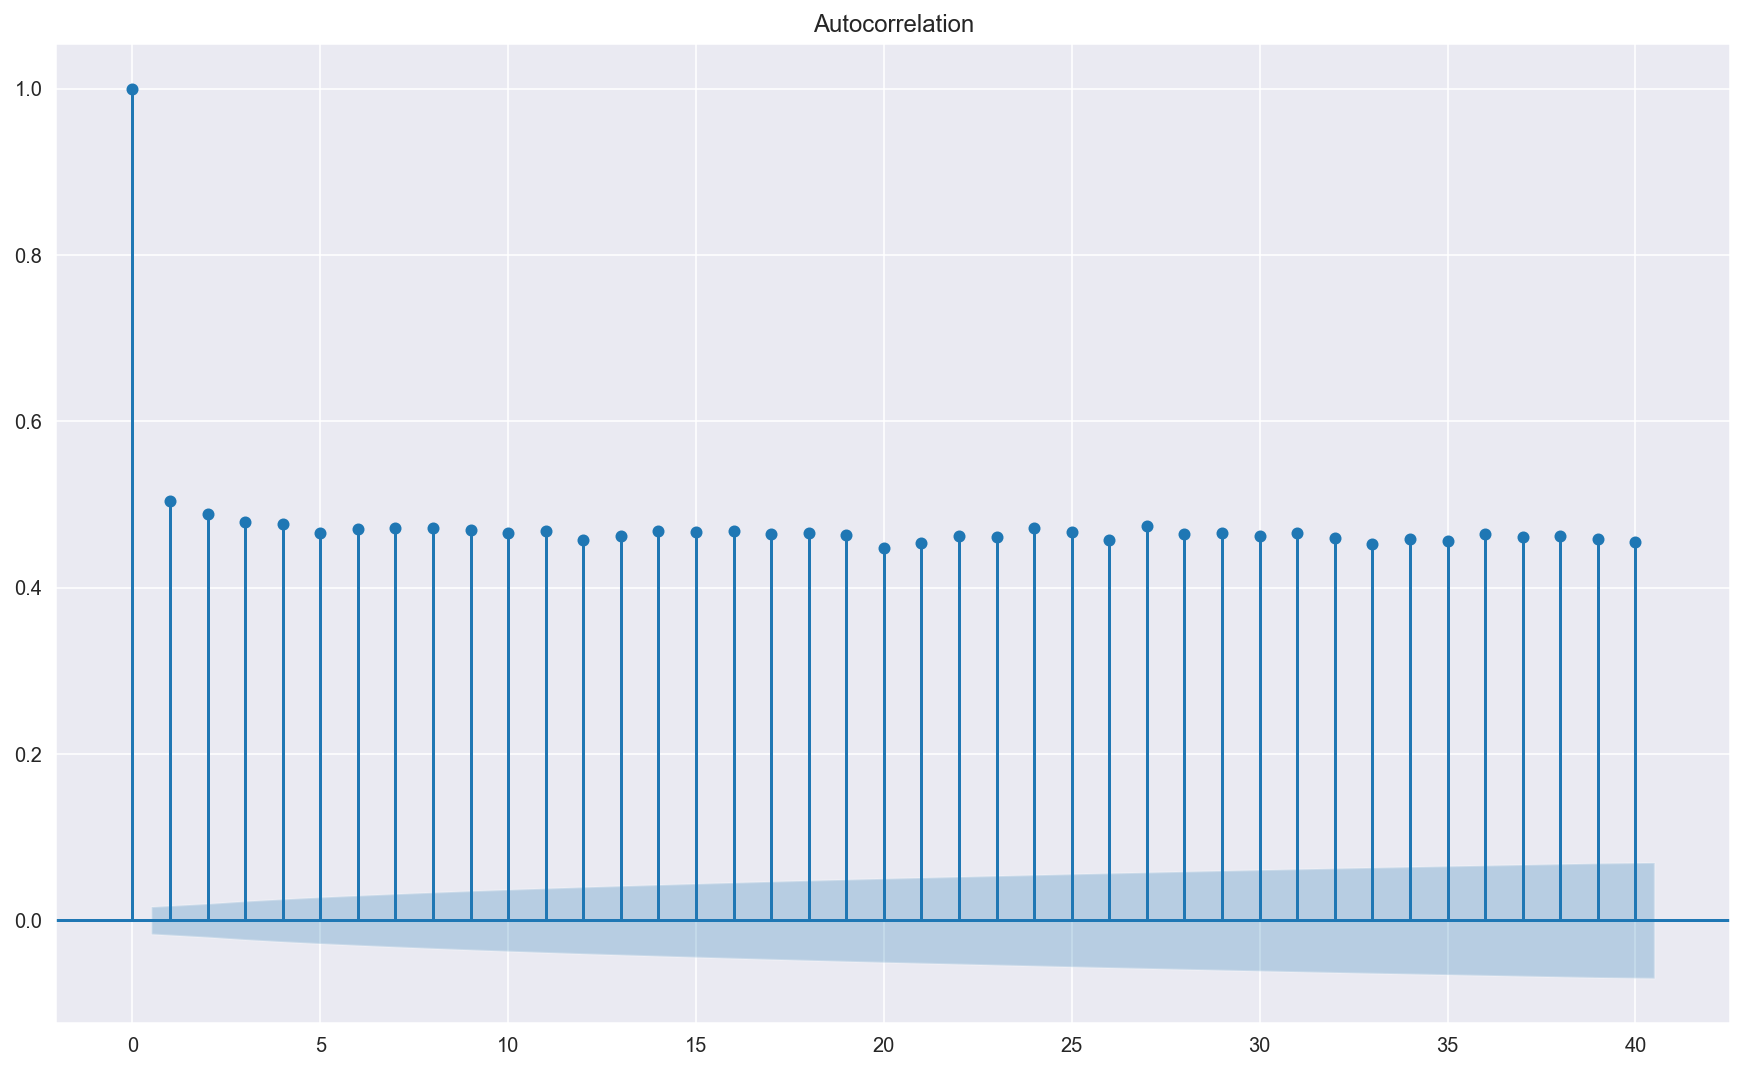

In [13]:


acf = smt.graphics.plot_acf(lin_reg.resid, lags=40 , alpha=0.05)
acf.show()

In [14]:



corr_test = pearsonr(file.mileage, lin_reg.resid)
print(f'Variable: Mileage --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')

Variable: Mileage --- correlation: -0.0000, p-value: 1.0000


C:\Users\samslomowitz\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\samslomowitz\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Jarque-Bera test ---- statistic: 2522.6789, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9616, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5590, p-value: 0.0000
Anderson-Darling test ---- statistic: 120.9344, 5% critical value: 0.7870
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


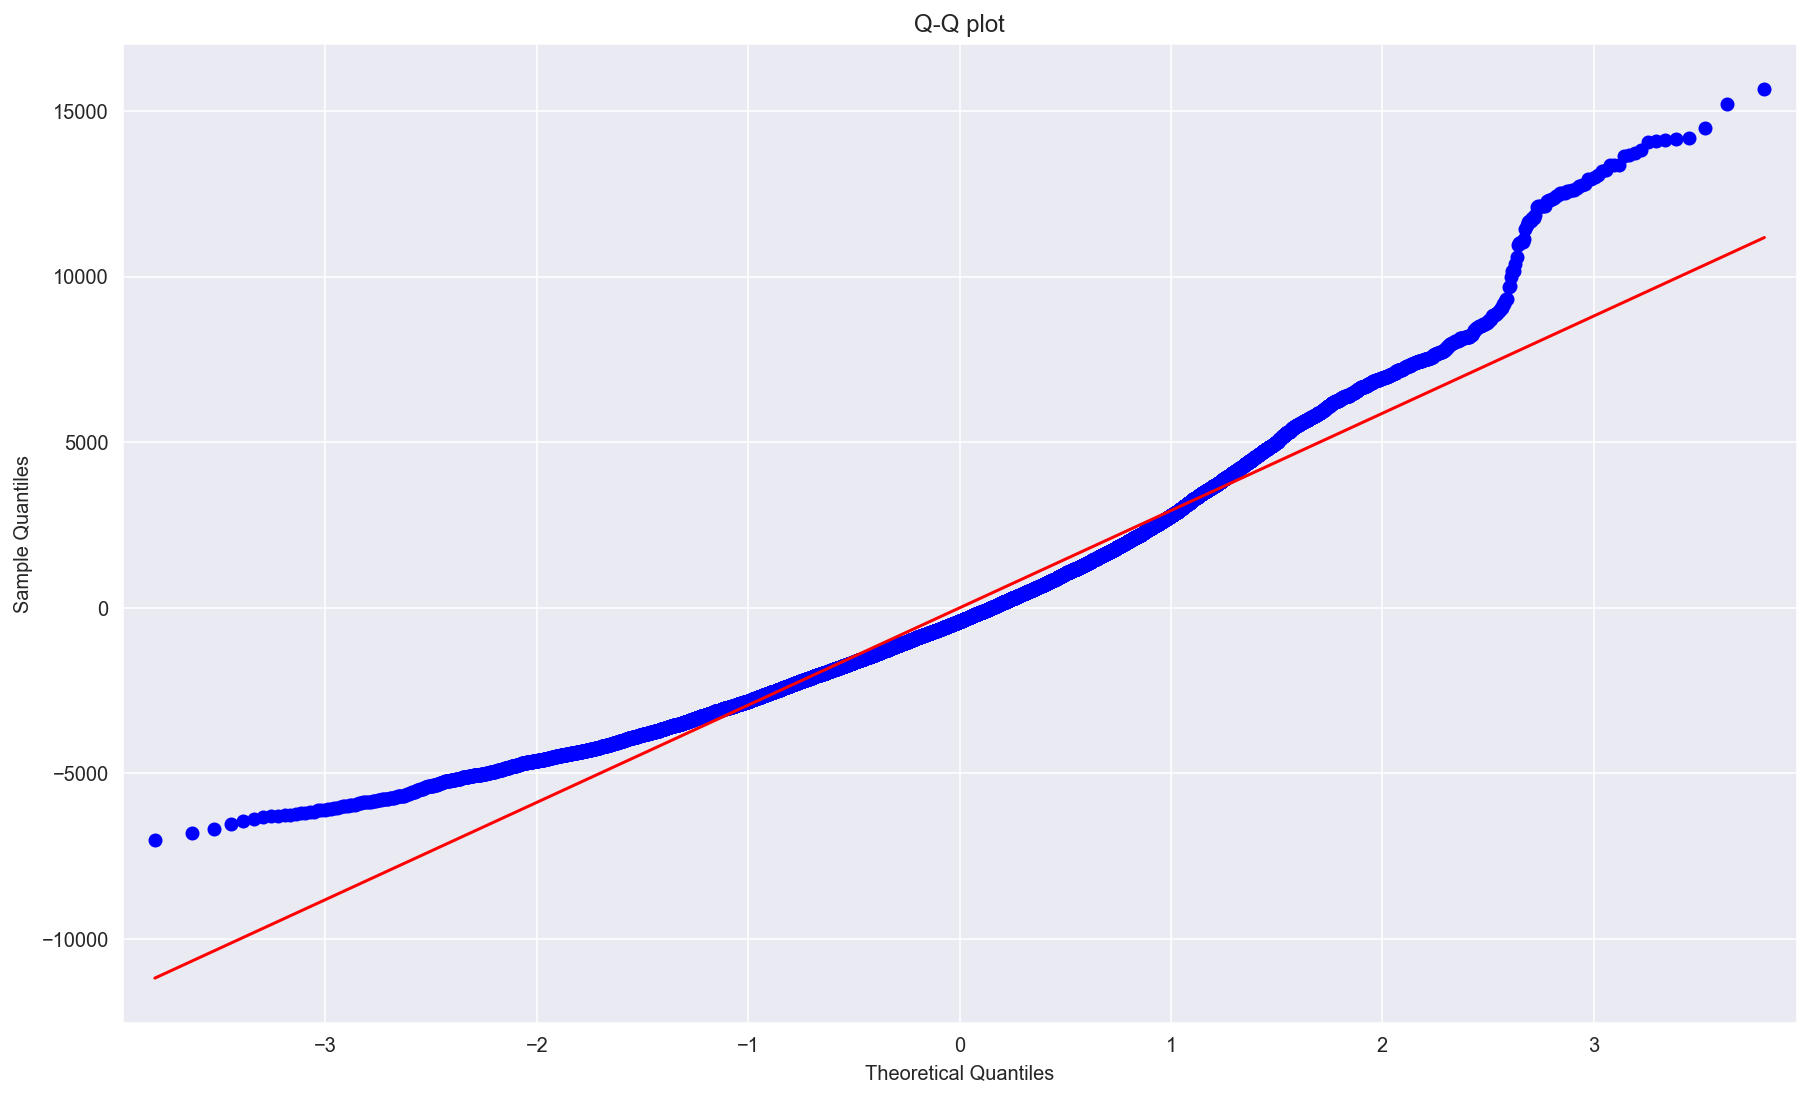

In [15]:


def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    
normality_of_residuals_test(lin_reg)

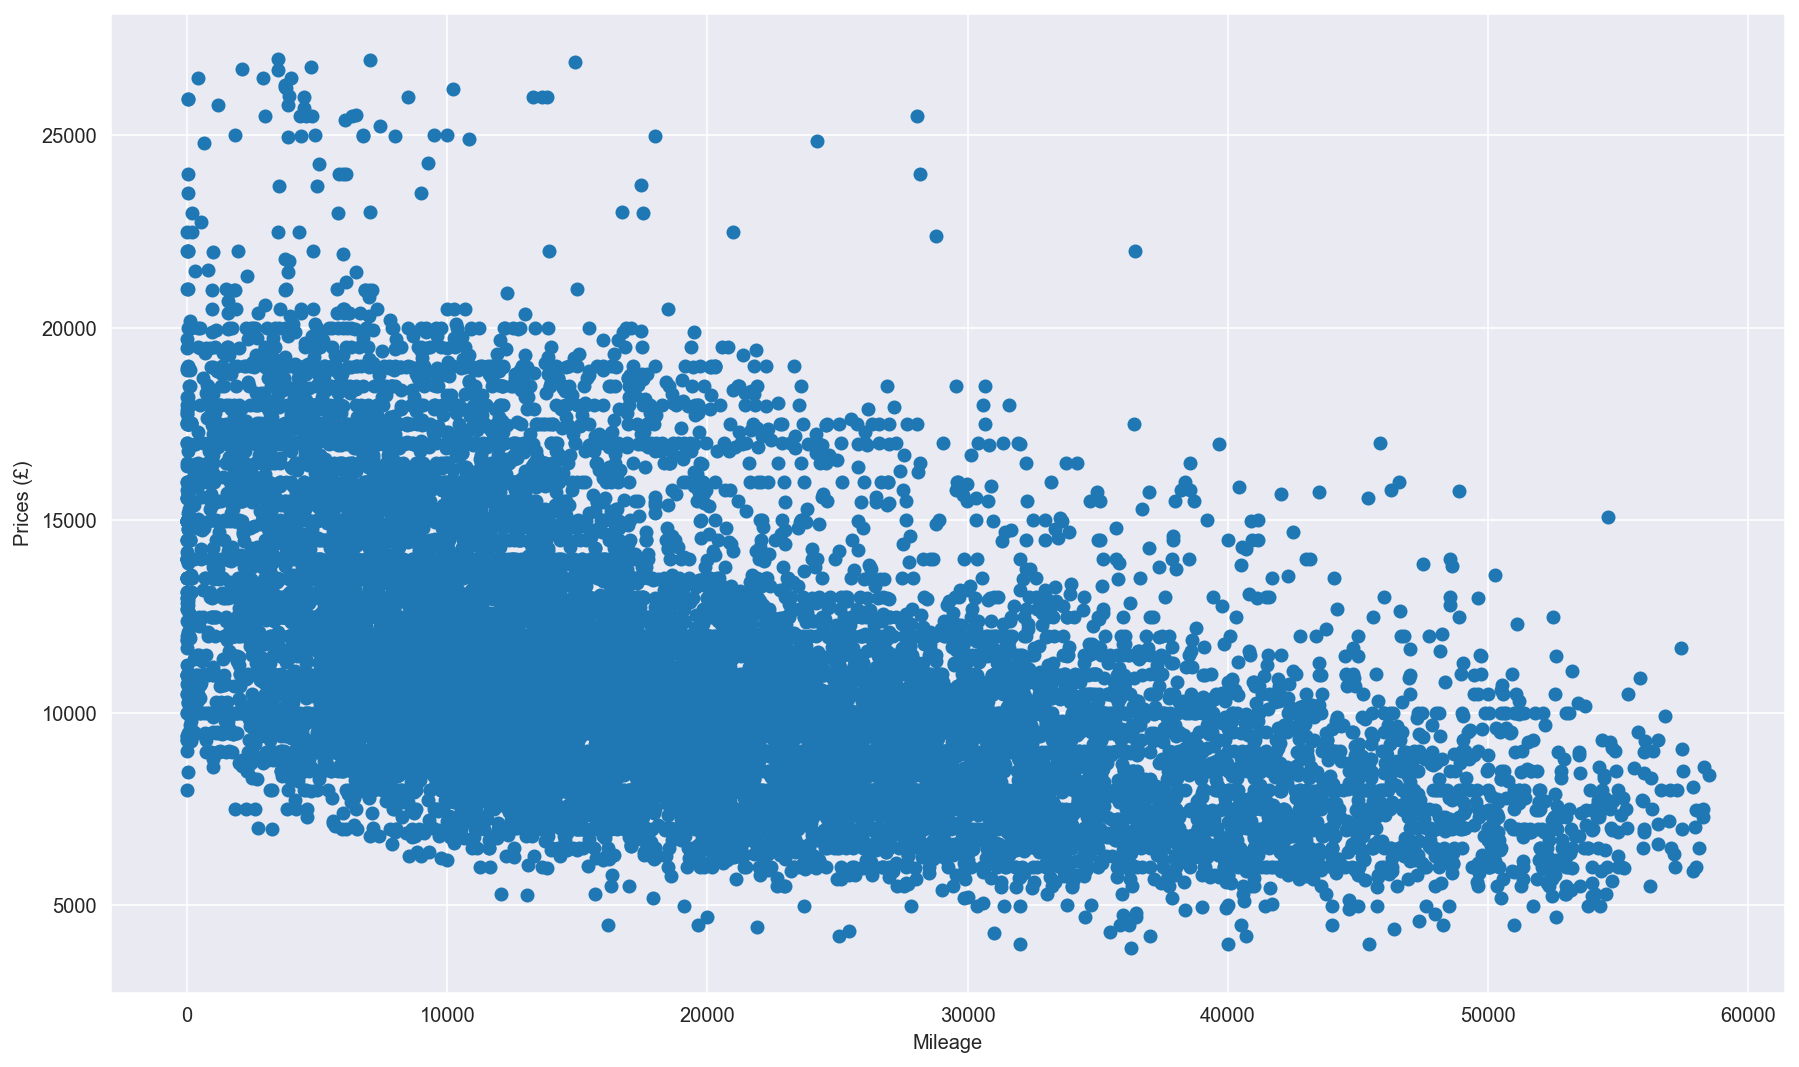

In [16]:
x_values = file['mileage']
y_values = file['price']
plt.scatter(x_values,y_values)
plt.xlabel('Mileage')
plt.ylabel('Prices (£)')
plt.show()

In [17]:
X_constant = sm.add_constant(file.mpg)
lin_reg = sm.OLS(file.price,X_constant).fit()
lin_reg.summary()

C:\Users\samslomowitz\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     1405.
Date:                Mon, 07 Feb 2022   Prob (F-statistic):          2.15e-293
Time:                        19:45:33   Log-Likelihood:            -1.3540e+05
No. Observations:               14233   AIC:                         2.708e+05
Df Residuals:                   14231   BIC:                         2.708e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.812e+04    188.271     96.254      0.000    1.78e+04    1.85e+04
mpg         -113.5489      3.029    -37.487      0.000    -119.486    -107.612
==============================================================================
Omnibus:                     1103.072   Durbin-Watson:                   1.201
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1379.418
Skew:                           0.728   Prob(JB):                    2.91e-300
Kurtosis:                       3.453   Cond. No.                         426.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The r-squared is: 0.08987485998936913


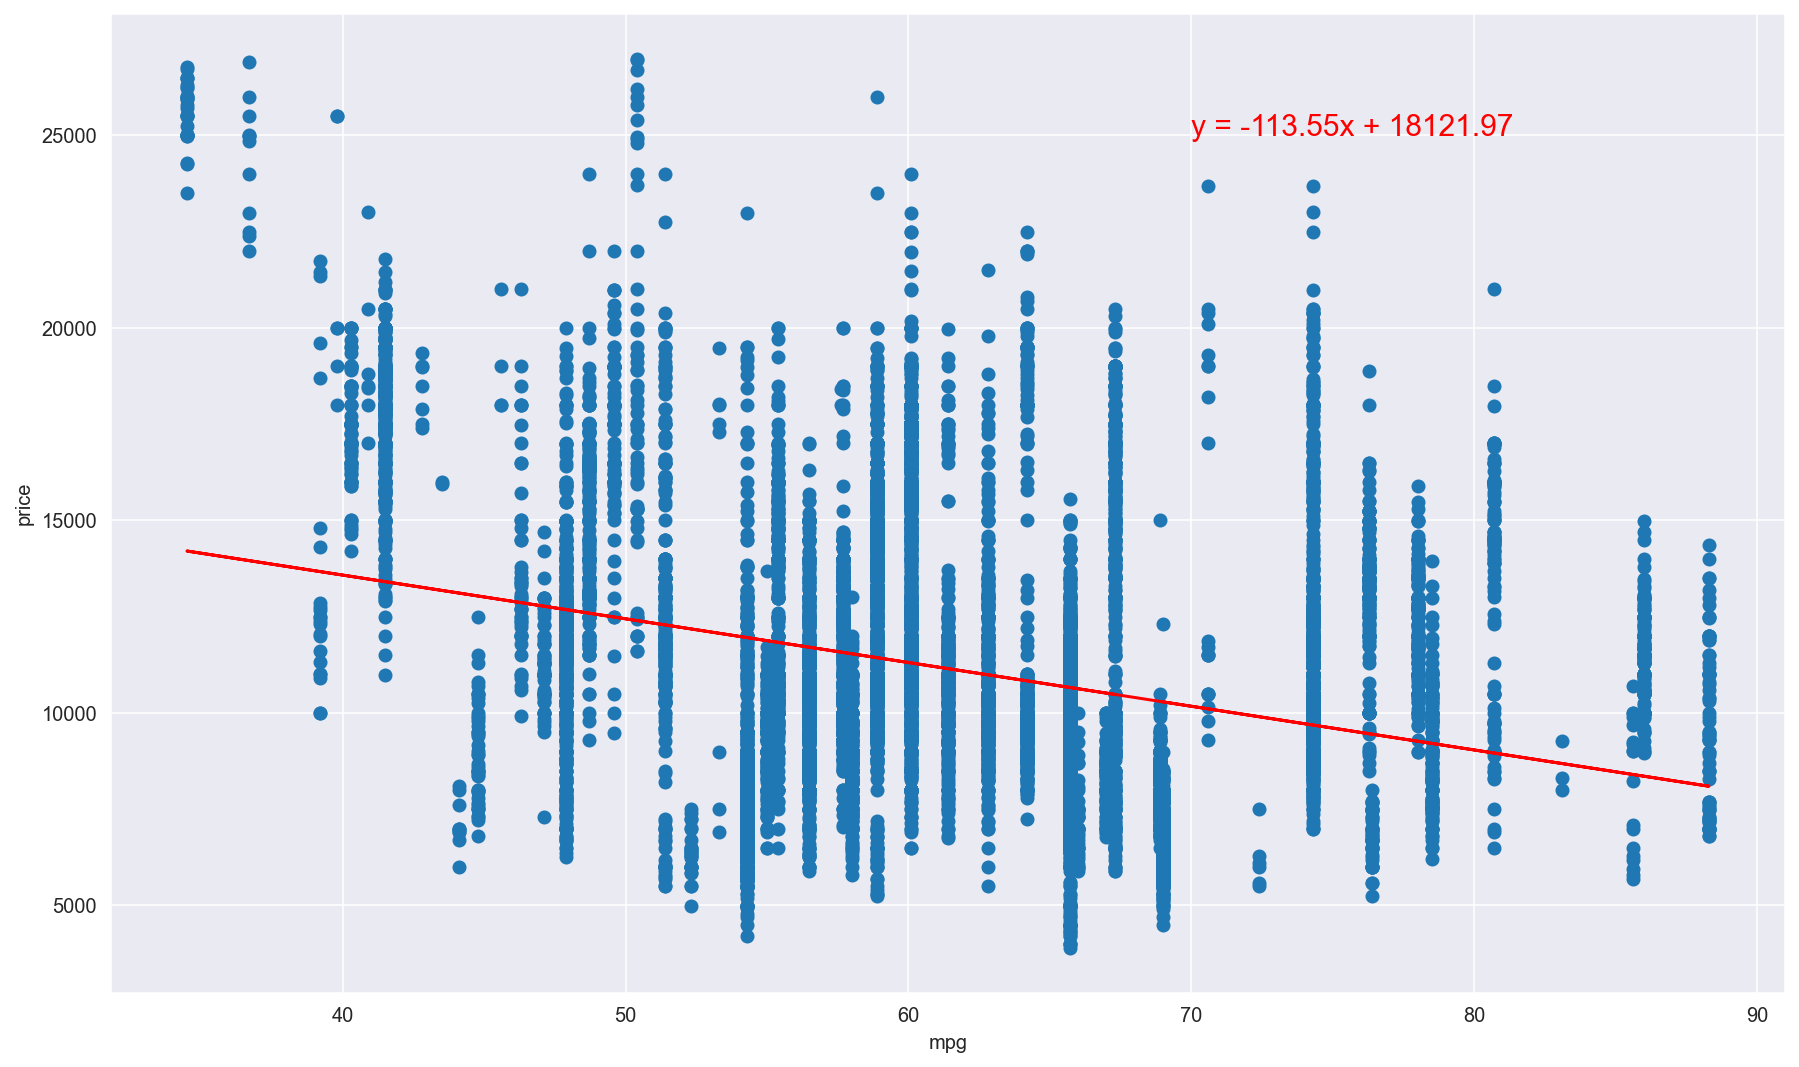

In [23]:
x_values = file['mpg']
y_values = file['price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(70,25000),fontsize=15,color="red")
plt.xlabel('mpg')
plt.ylabel('price')
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [18]:
X_constant = sm.add_constant(file.engineSize)
lin_reg = sm.OLS(file.price,X_constant).fit()
lin_reg.summary()

C:\Users\samslomowitz\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     1875.
Date:                Mon, 07 Feb 2022   Prob (F-statistic):               0.00
Time:                        19:46:05   Log-Likelihood:            -1.3519e+05
No. Observations:               14233   AIC:                         2.704e+05
Df Residuals:                   14231   BIC:                         2.704e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6245.0081    116.221     53.734      0.000    6017.199    6472.817
engineSize  4081.7719     94.260     43.303      0.000    3897.010    4266.534
==============================================================================
Omnibus:                      987.923   Durbin-Watson:                   1.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1203.130
Skew:                           0.701   Prob(JB):                    5.54e-262
Kurtosis:                       3.255   Cond. No.                         8.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The r-squared is: 0.11642599234251726


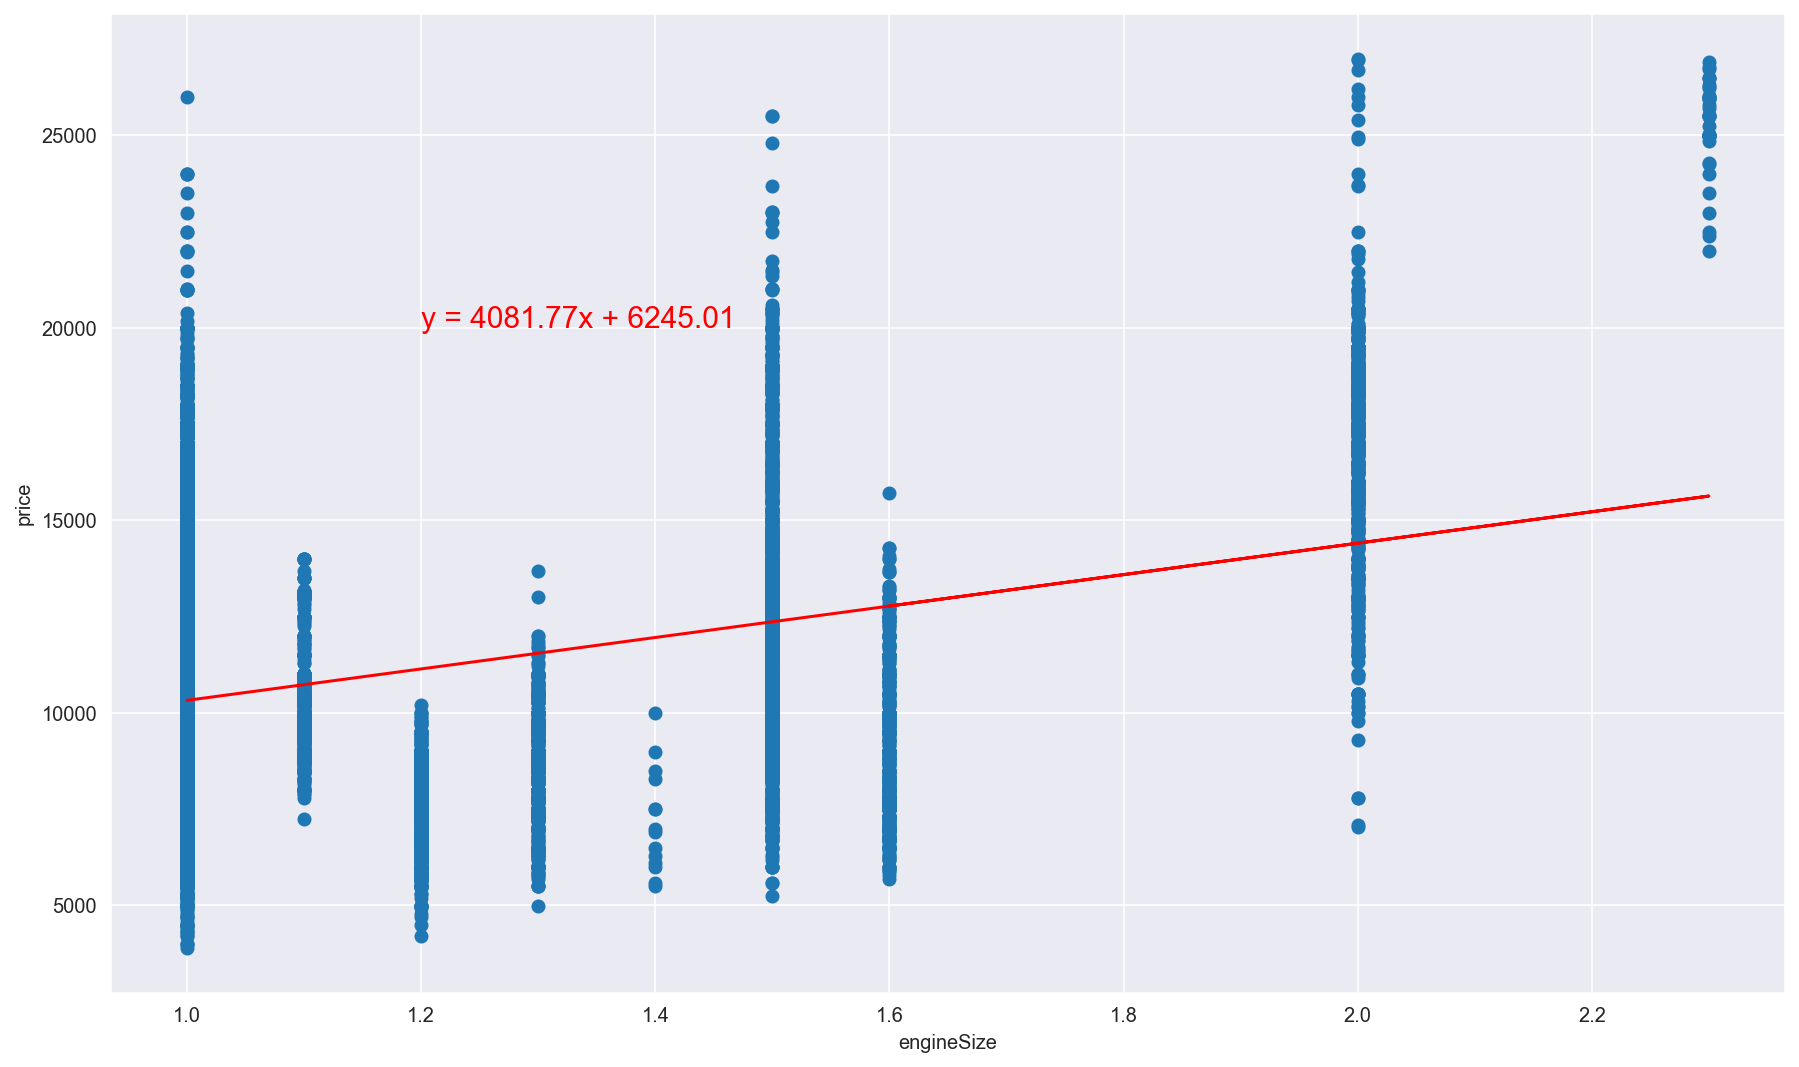

In [21]:
x_values = file['engineSize']
y_values = file['price']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1.2,20000),fontsize=15,color="red")
plt.xlabel('engineSize')
plt.ylabel('price')
print(f"The r-squared is: {rvalue**2}")
plt.show()